<h1>Proyecto (clasificación) usando SVM, RF, ET</h1>
<h2>Parcial 2</h2>
<p>Equipo:</p>
<p>José Carlos Chaparro Morales nya - 329613</p>
<p>Omar Alonso Escápita Chacón - 338886</p>

In [16]:
from sklearn.metrics import roc_curve, auc
def plot_multiclass_roc_auc(y_true, y_pred_proba, n_classes):
    # Calcular las curvas ROC y AUC para cada clase
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Graficar las curvas ROC y mostrar las AUC en la leyenda
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i}: AUC = {roc_auc[i]:.2f}")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de falsos positivos')
    plt.ylabel('Tasa de verdaderos positivos')
    plt.title('Curva ROC multiclase')
    plt.legend(loc="lower right")
    plt.show()

# Data Loading, Visualization and Preparation

## Loading the data

In [17]:
#!pip install transformers
#!pip install datasets
#!pip install -q kaggle
#!mkdir ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 ~/.kaggle/kaggle.json

In [18]:
import numpy as np 
import pandas as pd 
import os
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import transformers 
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader
import torch
from datasets import Dataset
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import string
import re
from nltk import pos_tag
from string import punctuation
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jc_ch\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jc_ch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jc_ch\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jc_ch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\jc_ch\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [19]:
import locale
##locale.getdefaultlocale()
print(locale.getpreferredencoding())

def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
    
locale.getpreferredencoding = getpreferredencoding



UTF-8


In [20]:
print(locale.getpreferredencoding())

UTF-8


In [21]:
!kaggle datasets download rmisra/news-category-dataset
#!unzip news-category-dataset.zip

news-category-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [22]:
list_dic = []

with open('News_Category_Dataset_v3.json') as json_file:
    for the_file in json_file:
        list_dic.append(json.loads(the_file))

len(list_dic)

209527

In [23]:
data = pd.DataFrame(list_dic)
data.shape

(209527, 6)

## Looking at the data

In [24]:
data.isnull().sum()

link                 0
headline             0
category             0
short_description    0
authors              0
date                 0
dtype: int64

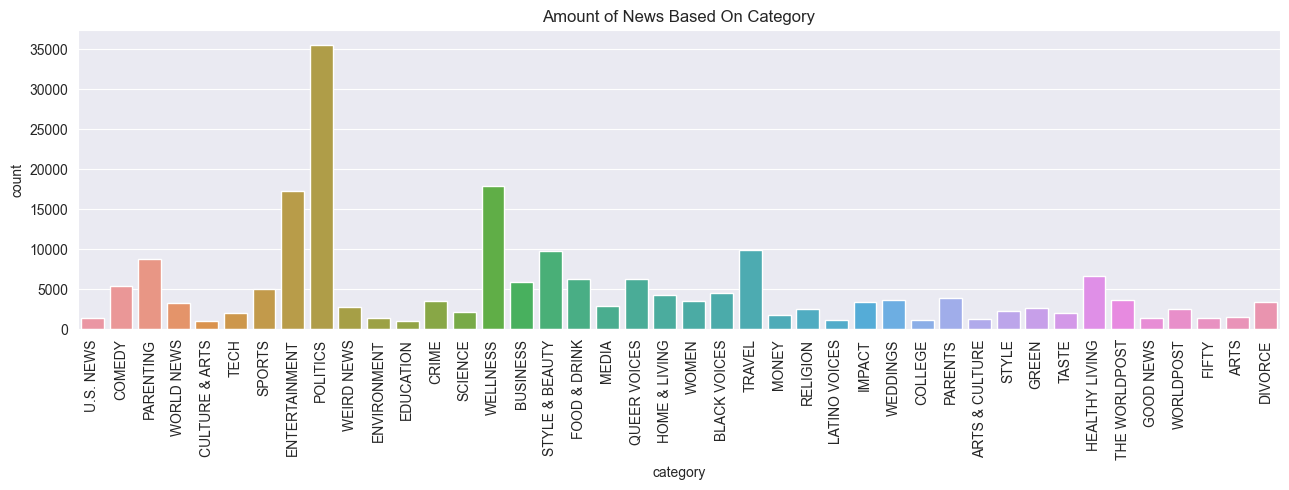

In [25]:
plt.figure(figsize=(13, 5))
plt.title('Amount of News Based On Category')
sns.countplot(data=data, x='category')
plt.xticks(rotation=90)
plt.tight_layout()

In [26]:
for i in range (0,209527):
    if(len(word_tokenize(data['short_description'][i])) == 0):
        data['short_description'][i] = np.nan

In [27]:
data = data.dropna()
data=data.reset_index(drop=True)
data.shape

(189815, 6)

In [28]:
data['short_description'] = data['headline'] + '. ' + data['short_description']
data = data.drop(['link', 'headline','authors', 'date'], axis=1)

In [29]:
data.head(3)

,category,short_description
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li..."
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...


In [30]:
data.loc[data['category']=='PARENTING', 'category'] = 'PARENTS'
data.loc[data['category']=='THE WORLDPOST', 'category'] = 'WORLD NEWS'
data.loc[data['category']=='BLACK VOICES', 'category'] = 'VOICES'
data.loc[data['category']=='QUEER VOICES', 'category'] = 'VOICES'
data.loc[data['category']=='LATINO VOICES', 'category'] = 'VOICES'
data.loc[data['category']=='WEDDINGS', 'category'] = 'WEDDINGS & DIVORCE'
data.loc[data['category']=='DIVORCE', 'category'] = 'WEDDINGS & DIVORCE'
data.loc[data['category']=='HEALTHY LIVING', 'category'] = 'WELLNESS'
data.loc[data['category']=='ARTS', 'category'] = 'ARTS & CULTURE'
data.loc[data['category']=='CULTURE & ARTS', 'category'] = 'ARTS & CULTURE'

In [31]:
clases = data['category'].unique()

for i in clases:
  indexes = data.index[data['category'] == i].tolist()
  drop_i = indexes[:(len(indexes)-len(indexes)//20)]
  if (len(drop_i) > 0):
    data.drop(drop_i, axis=0, inplace=True)
    data=data.reset_index(drop=True)

data.shape

(9478, 2)

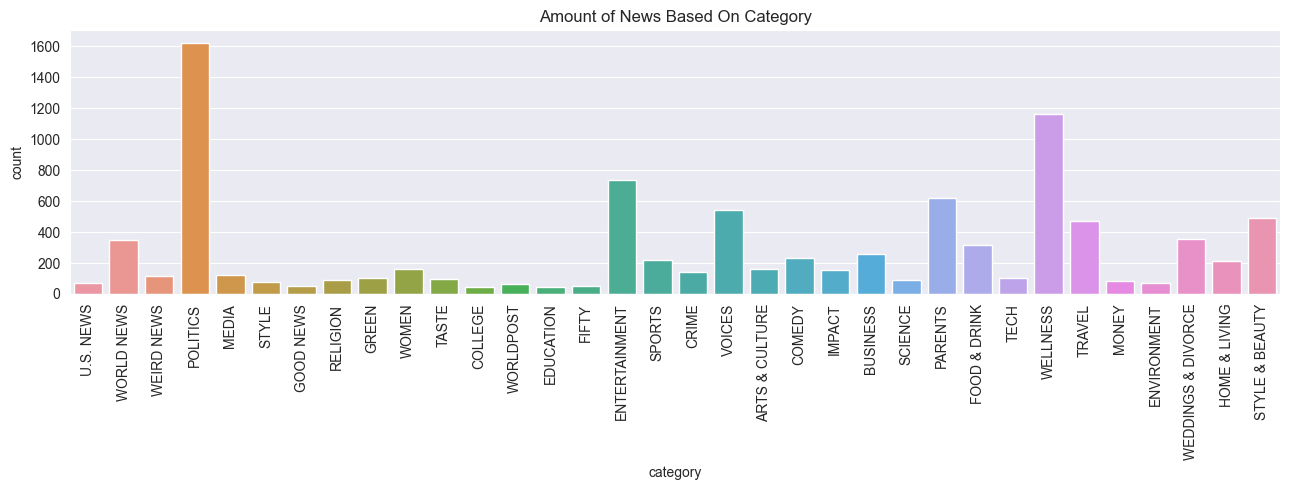

In [32]:
plt.figure(figsize=(13, 5))
plt.title('Amount of News Based On Category')
sns.countplot(data=data, x='category')
plt.xticks(rotation=90)
plt.tight_layout()

## Data cleaning

In [33]:
REMOVE_SPECIAL_CHARACTER = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS = re.compile('[^0-9a-z #+_]')

STOPWORDS = set(stopwords.words('english'))
punctuation = list(punctuation)
STOPWORDS.update(punctuation)

lemmatizer = WordNetLemmatizer()

def get_simple_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def clean_text(text):
    # part 1
    text = text.lower() # lowering text
    text = REMOVE_SPECIAL_CHARACTER.sub('', text) # replace REPLACE_BY_SPACE symbols by space in text
    text = BAD_SYMBOLS.sub('', text) # delete symbols which are in BAD_SYMBOLS from text
    
    # part 2
    clean_text = []
    for w in word_tokenize(text):
        if w.lower() not in STOPWORDS:
            pos = pos_tag([w])
            new_w = lemmatizer.lemmatize(w, pos=get_simple_pos(pos[0][1]))
            clean_text.append(new_w)
    text = " ".join(clean_text)
    
    return text

In [34]:
data['short_description'] = data['short_description'].apply(clean_text)

## Data preparation

In [35]:
X= data['short_description']
y= data['category']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [37]:
encoder = LabelEncoder()

In [38]:
y_train= encoder.fit_transform(y_train)
y_test= encoder.transform(y_test)

In [39]:
tf_idf_vect = TfidfVectorizer(ngram_range =(1,1))

In [40]:
final_tf_idf = tf_idf_vect.fit_transform(X_train)

In [41]:
final_tf_idf_test = tf_idf_vect.transform(X_test)

# Support Vector Classifier

### Grid search


In [42]:
svc_clf_param_grid = [
    {'kernel': ['linear', 'poly', 'sigmoid'], 'degree': [2,4,5]},
    {'C': [1, 10, 100]},
    ]

svc_clf = SVC()

svc_clf_grid_search = GridSearchCV(svc_clf, svc_clf_param_grid, cv=5)
svc_clf_grid_search.fit(final_tf_idf, y_train)
best=svc_clf_grid_search.best_params_

In [43]:
print(best)

In [44]:
xd=SVC(probability=True,kernel=best['kernel'],degree=best['degree'])
xd.fit(final_tf_idf, y_train)

In [45]:
print("Best estimator: ", svc_clf_grid_search.best_estimator_)

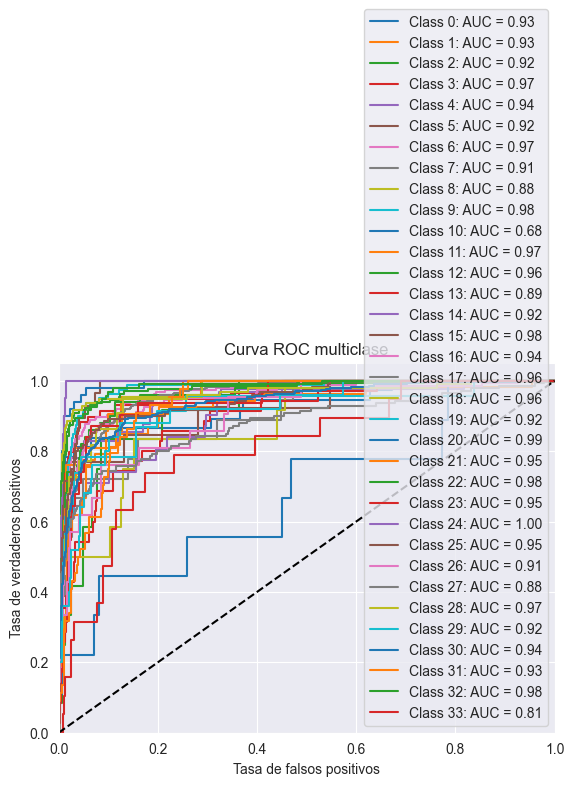

In [46]:
import joblib
final_model_SVC=joblib.load("svc.pkl")

n_classes = len(np.unique(y_test))
probauwu=final_model_SVC.predict_proba(final_tf_idf_test)
plot_multiclass_roc_auc(y_test,probauwu,n_classes)

### Evaluate on the Test set

In [48]:
final_model_SVC = svc_clf_grid_search.best_estimator_

final_model_SVC.fit(final_tf_idf, y_train)

y_pred_SVC = final_model_SVC.predict(final_tf_idf_test)

# Extra Trees

### Grid Search

In [49]:
extra_tree_clf_param_grid = [
    {'criterion': ['gini', 'entropy'], 'max_depth': [ 10, 15]},
    {'max_depth': [5, 10], 'min_samples_split': [2,5]},
    {'min_samples_split': [2,4], 'min_samples_leaf': [2, 4]}
    ]

extra_tree_clf = ExtraTreeClassifier()

extra_tree_clf_grid_search = GridSearchCV(extra_tree_clf, extra_tree_clf_param_grid, cv=5)

extra_tree_clf_grid_search.fit(final_tf_idf, y_train)

GridSearchCV(cv=5, estimator=ExtraTreeClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [10, 15]},
                         {'max_depth': [5, 10], 'min_samples_split': [2, 5]},
                         {'min_samples_leaf': [2, 4],
                          'min_samples_split': [2, 4]}])

In [50]:
print("Best estimator: ",extra_tree_clf_grid_search.best_estimator_)

#import joblib
#joblib.dump(extra_tree_reg_grid_search, "extra_tree_reg.pkl")

Best estimator:  ExtraTreeClassifier(min_samples_leaf=2, min_samples_split=4)


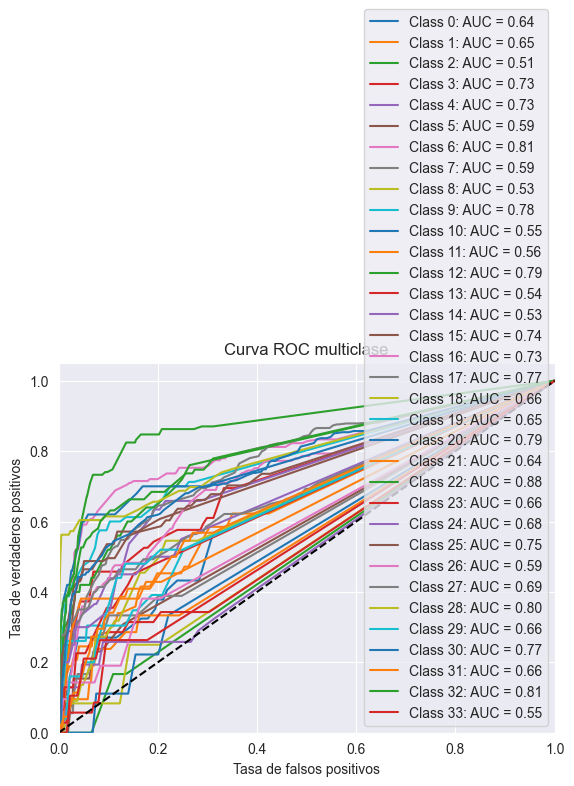

In [51]:
probauwu=extra_tree_clf_grid_search.best_estimator_.predict_proba(final_tf_idf_test)
plot_multiclass_roc_auc(y_test,probauwu,n_classes)

### Training model with best parameters

In [52]:
final_model_ET = extra_tree_clf_grid_search.best_estimator_

final_model_ET.fit(final_tf_idf, y_train)

y_pred_ET = final_model_ET.predict(final_tf_idf_test)

In [53]:
import joblib
joblib.dump(final_model_ET, "extra_tree_clf.pkl")

['extra_tree_clf.pkl']

# Random Forest

### Grid search

In [54]:
forest_clf_param_grid = [
    {'criterion': ['gini', 'log_loss'], 'n_estimators': [ 50, 100]},
    {'max_depth': [5, 10], 'min_samples_split': [2,5]},
    {'n_jobs': [1,-1], 'min_samples_leaf': [2, 4]}
    ]

forest_clf = RandomForestClassifier()

forest_clf_grid_search = GridSearchCV(forest_clf, forest_clf_param_grid, cv=5)

forest_clf_grid_search.fit(final_tf_idf, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'criterion': ['gini', 'log_loss'],
                          'n_estimators': [50, 100]},
                         {'max_depth': [5, 10], 'min_samples_split': [2, 5]},
                         {'min_samples_leaf': [2, 4], 'n_jobs': [1, -1]}])

In [55]:
print("Best estimator: ", forest_clf_grid_search.best_estimator_)

Best estimator:  RandomForestClassifier(min_samples_leaf=2, n_jobs=1)


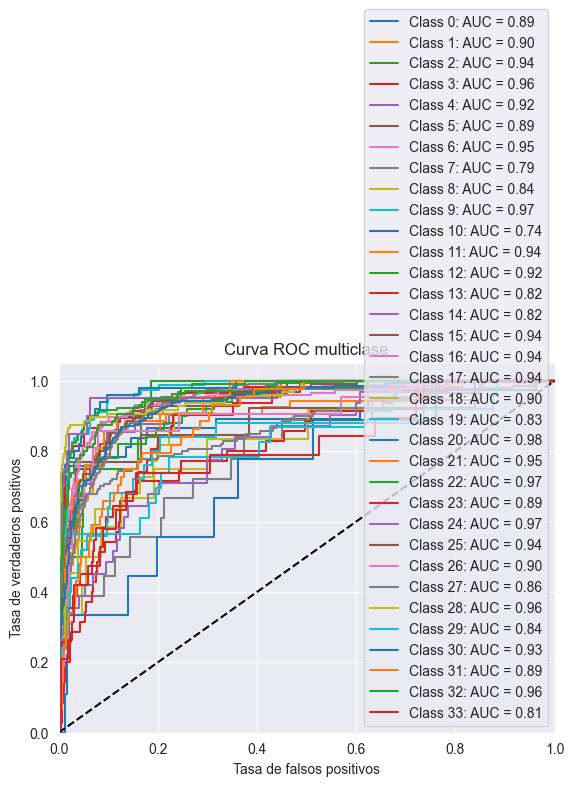

In [56]:
probauwu=forest_clf_grid_search.best_estimator_.predict_proba(final_tf_idf_test)
plot_multiclass_roc_auc(y_test,probauwu,n_classes)

### Training model with best parameters

In [57]:
final_model_RF = forest_clf_grid_search.best_estimator_

final_model_RF.fit(final_tf_idf, y_train)

y_pred_RF = final_model_RF.predict(final_tf_idf_test)

In [58]:
joblib.dump(final_model_ET, "forest_clf_grid_search.pkl")

['forest_clf_grid_search.pkl']

# Results

In [59]:
import joblib
final_model_SVC = joblib.load("svc.pkl")
final_model_ET = joblib.load("extra_tree_clf.pkl")
final_model_RF = joblib.load("forest_clf_grid_search.pkl")

y_pred_SVC = final_model_SVC.predict(final_tf_idf_test)
y_pred_ET = final_model_ET.predict(final_tf_idf_test)
y_pred_RF = final_model_RF.predict(final_tf_idf_test)



In [60]:
print("Results SVC: ")
print("Accuracy: ", accuracy_score(y_test, y_pred_SVC))
print("F1 score: ", f1_score(y_test, y_pred_SVC, average='weighted'))
print("Precision score: ", precision_score(y_test, y_pred_SVC, average='weighted', zero_division=1))
print("Recall score: ", recall_score(y_test, y_pred_SVC, average='weighted'), "\n")

print("Results ET: ")
print("Accuracy: ", accuracy_score(y_test, y_pred_ET))
print("F1 score: ", f1_score(y_test, y_pred_ET, average='weighted'))
print("Precision score: ", precision_score(y_test, y_pred_ET, average='weighted', zero_division=1))
print("Recall score: ", recall_score(y_test, y_pred_ET, average='weighted'), "\n")

print("Results RF: ")
print("Accuracy: ", accuracy_score(y_test, y_pred_RF))
print("F1 score: ", f1_score(y_test, y_pred_RF, average='weighted'))
print("Precision score: ", precision_score(y_test, y_pred_RF, average='weighted', zero_division=1))
print("Recall score: ", recall_score(y_test, y_pred_RF, average='weighted'), "\n")

Results SVC: 
Accuracy:  0.6037974683544304
F1 score:  0.5619099841852475
Precision score:  0.6564375597117947
Recall score:  0.6037974683544304 

Results ET: 
Accuracy:  0.41729957805907175
F1 score:  0.3879272572246901
Precision score:  0.42485772460206733
Recall score:  0.41729957805907175 

Results RF: 
Accuracy:  0.41729957805907175
F1 score:  0.3879272572246901
Precision score:  0.42485772460206733
Recall score:  0.41729957805907175 



# Deploying SVC

In [61]:
import joblib

joblib.dump(final_model_SVC, "model.pkl")

['model.pkl']